In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer

import xgboost as xgb

In [4]:
def combined_dataset(targetName):
    train = pd.read_csv("data/train.csv")
    test = pd.read_csv("data/test.csv")
    train.drop(targetName, 1, inplace=True)
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop('index', inplace=True, axis=1)
    
    return combined, train.shape[0]

In [5]:
combined, idx = combined_dataset('SalePrice')

In [6]:
# remove missing data

In [7]:
combined["PoolQC"].fillna("No", inplace=True)
combined["PoolArea"].fillna(0, inplace=True)
combined['MiscFeature'].fillna('None', inplace=True)
combined['Alley'].fillna('None', inplace=True)
combined['Fence'].fillna('None', inplace=True)
combined['FireplaceQu'].fillna('None', inplace=True)
combined['LotFrontage'].fillna(0, inplace=True)
combined['GarageYrBlt'].fillna(combined['YearBuilt'], inplace=True)
combined["GarageType"].fillna("None", inplace=True)
combined["GarageQual"].fillna("None", inplace=True)
combined["GarageCond"].fillna("None", inplace=True)
combined["GarageFinish"].fillna("None", inplace=True)
combined['BsmtFinType1'].fillna('None', inplace=True)
combined['BsmtFinType2'].fillna('None', inplace=True)
combined['BsmtExposure'].fillna('None', inplace=True)
combined['BsmtQual'].fillna('None', inplace=True)
combined['BsmtCond'].fillna('None', inplace=True)
combined['MasVnrType'].fillna('None', inplace=True)
combined['MasVnrArea'].fillna(0, inplace=True)
combined['Electrical'].fillna('None', inplace=True)
combined['GarageCars'].fillna(0, inplace=True)
combined['KitchenQual'].fillna(0, inplace=True)
combined['MSZoning'].fillna('None', inplace=True)
combined['Utilities'].fillna('None', inplace=True)
combined['Functional'].fillna('None', inplace=True)
combined['BsmtFullBath'].fillna(0, inplace=True)
combined['BsmtHalfBath'].fillna(0, inplace=True)
combined['Exterior1st'].fillna('None', inplace=True)
combined['Exterior2nd'].fillna('None', inplace=True)
combined['GarageArea'].fillna(0, inplace=True)
combined['BsmtFinSF2'].fillna(0, inplace=True)
combined['BsmtFinSF1'].fillna(0, inplace=True)
combined['SaleType'].fillna('None', inplace=True)
combined['TotalBsmtSF'].fillna(0, inplace=True)
combined['BsmtUnfSF'].fillna(0, inplace=True)

In [8]:
combined.isnull().sum().max()

0

In [9]:
# some numerical features are actually categories. 
def add_prefix(x):
    return 'SC' + str(x)

combined.MSSubClass = combined.MSSubClass.apply(add_prefix)

In [10]:
import calendar

combined['MoSold'] = combined['MoSold'].apply(lambda x: calendar.month_abbr[x])

In [11]:
categorical_features = combined.select_dtypes(include = ["object"]).columns
numerical_features = combined.select_dtypes(exclude = ["object"]).columns

In [12]:
# convert all categorical variables into numeric

combined = pd.get_dummies(combined)

In [13]:
types = combined.columns.to_series().groupby(combined.dtypes).groups
for k,v in types.items():
    print(k, v)

uint8 Index(['MSSubClass_SC120', 'MSSubClass_SC150', 'MSSubClass_SC160',
       'MSSubClass_SC180', 'MSSubClass_SC190', 'MSSubClass_SC20',
       'MSSubClass_SC30', 'MSSubClass_SC40', 'MSSubClass_SC45',
       'MSSubClass_SC50',
       ...
       'SaleType_New', 'SaleType_None', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=302)
int64 Index(['Id', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold'],
      dtype='object')
float64 Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBs

In [14]:
combined.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,1,1,0,0,0,0,0
4,5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [15]:
# modeling

def get_original_datasets(idx, target):
    global combined
    
    train0 = pd.read_csv('data/train.csv')
    
    targets = train0[target]
    train = combined.head(idx)
    test = combined.iloc[idx:]
    
    return train, test, targets

train, test, targets = get_original_datasets(idx, 'SalePrice')
targets = np.log1p(targets)

In [16]:
train.drop('Id', inplace=True, axis=1)
test.drop('Id', inplace=True, axis=1)

columns = train.columns

C:\Users\sergio\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\sergio\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
X_train, X_test, y_train, y_test = train_test_split(train, targets, test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1022, 336)
(438, 336)
(1022,)
(438,)


In [18]:
# methods for validation

scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

[0]	train-rmse:10.9552	test-rmse:10.9552
[50]	train-rmse:0.877661	test-rmse:0.879034
[100]	train-rmse:0.111259	test-rmse:0.156981
[150]	train-rmse:0.0595647	test-rmse:0.131813
[200]	train-rmse:0.0452797	test-rmse:0.129676
[250]	train-rmse:0.035521	test-rmse:0.128425
[300]	train-rmse:0.0282517	test-rmse:0.128075
[350]	train-rmse:0.0227063	test-rmse:0.127877
[400]	train-rmse:0.0182987	test-rmse:0.127866


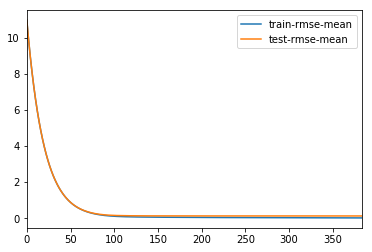

In [23]:

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(test)
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [24]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

In [25]:

y_pred = model.predict(dtest)

In [27]:
df_output = pd.DataFrame()
aux = pd.read_csv('data/test.csv')
df_output['Id'] = aux['Id']
df_output['SalePrice'] = y_pred

df_output[['Id','SalePrice']].to_csv('submissions/sn_submission.csv',index=False)